## Introduction to trust region samping

In this notebook we briefly explain our trust region samplig.

Lets start with quoting [wikipedia](https://en.wikipedia.org/wiki/Trust_region)

> In mathematical optimization, a trust region is the subset of the region of the
> objective function that is approximated using a model function (often a quadratic).

A trust region is thus a space over which the criterion (objective) function is evaluated to build an approximation model. Using the information from the approximation model and the true evaluations, trust region optimizers decide on how to move (or shrink/expand) the trust region, until the optimizer convergences. There is a clear trade-off between building an accurate approximation model (evaluate many points inside the region) and runtime. To mitigate this problem we use two main ideas. First, we fill the region with evaluation points such that certain criteria are fulfilled / optimized. This results in (optimal) [Latin Hypercube samples](https://en.wikipedia.org/wiki/Latin_hypercube_sampling). Using these points can increase the accuracy of the approximation model compared to naively using random samples inside the region. And second, we recycle previous evaluation to reduce runtime. Below we go through a visual example. Before we will explain what an optimal Latin Hypercube is.


### Latin Hypercube

A Latin Hypercube sample is a sample from a multivariate distribution that fulfills certain properties. Most often the samples are defined over a cube. For the sake of exposition consider the two-dimensional case and imagine that the square is partioned using equidistant grid lines. A sample of points from this square is a Latin Hypercube sample if (and only if) in each row and in each column there is only *one* point. If an equidistant grid is used, the resulting sample will resemble a sample from the Uniform distribution, which can be transformed to samples from other distributions using standard methods. But what makes a sample *optimal*?

**Optimality**

For a given number of gridlines per axis one can find **many** samples that fulfill the above property. As an example, say the point sampled is always at the center of row-column location. Say we have $n$ rows and columns. Then a Latin Hypercube sample consists of $n$ points, and the number of unique cubes is equal to $(n!)^d$, with $d$ being the dimensionality of the points. Hence, the set of possible cubes is quite large. Not every instance is desired though. Certain Latin Hypercubes have additional desirable properties. In particular we are interested in [optimal designs](https://en.wikipedia.org/wiki/Optimal_design). As an example. Let $X$ denote the Latin Hypercube sample ($n \times p$). If we build a linear model using this sample, the OLS estimates have a conditional variance proportional to $(X^T X)^{-1}$. Therefore, one may want to choose a specific cube for which this value is small. We follow a simple strategy to select such a cube: Simulate many cubes, pick the cube that minimizes the optimality-criterion. For an almost complete list of criteria click on the above link. Currently implemented criteria are "a-optimality", "d-optimality", "e-optimality", "g-optimality" and "maximin". The maximin criterion is not found in the above link. However, it is very simple: One computes the distances between all pairs of points, and maximizes the minimum of these distances. In comparison to the optimality criteria listed in the link, this will lead to a space filling design.

---

### Visual Example

To better grasp what acutally happens, let us consider a visual example. Let us first import all relevant libraries and define a plotting function.

In [1]:
import itertools

import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle

import estimagic as em
from estimagic.optimization.trust_region_sampling import (
    get_existing_points,
    get_next_trust_region_points_latin_hypercube,
)

np.random.seed(0)

In [2]:
def plot_sample(*samples, frames=[]):
    ax = None
    color = itertools.cycle(("darkblue", "firebrick"))
    for k, sample in enumerate(samples):
        ax = sns.regplot(
            x=sample[:, 0],
            y=sample[:, 1],
            fit_reg=False,
            ax=ax,
            color=next(color),
            scatter_kws={"alpha": 0.4},
        )
    frames = [frames] if not isinstance(frames, list) else frames
    for frame in frames:
        ax.add_patch(
            Rectangle(
                frame[0] - frame[1],
                2 * frame[1],
                2 * frame[1],
                fill=False,
            )
        )
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

Now we create a 2-dimensional Latin-Hypercube with 30 points. The cube has its center at (0.4, 0.4) and a radius of 0.3. Here we use the e-optimality criterion and select the best cube from 50,000 iterations.

In [3]:
def random_sample(center, radius, n_points):
    lower = center - radius
    upper = center + radius
    points = np.random.uniform(low=lower, high=upper, size=(n_points, len(center)))
    return points

In [4]:
dim = 2
n_points = 20

first_center = np.ones(dim) * 0.4
first_radius = 0.3

first_points_dict = get_next_trust_region_points_latin_hypercube(
    center=first_center,
    radius=first_radius,
    n_points=n_points,
    n_iter=100_000,
    optimality_criterion="maximin",
)

first_sample = first_points_dict["points"]
crit_vals = first_points_dict["crit_vals"]

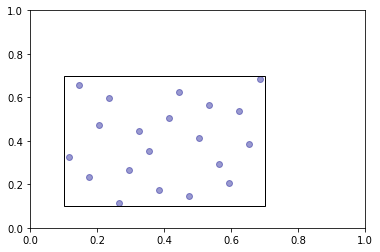

In [5]:
plot_sample(first_sample, frames=(first_center, first_radius))

In [6]:
uniform_sample = random_sample(first_center, first_radius, n_points)

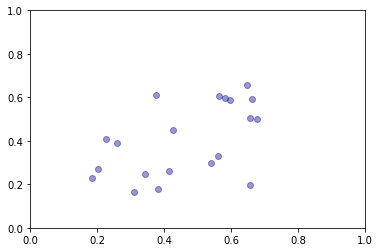

In [7]:
plot_sample(uniform_sample)

In the optimization use case the optimizer would perform its magic on this first sample. If convergence is not achieved the algorithm will propose an update step. This can be a shift of the radius or the center of the cube. Say we shift the center to (0.6, 0.6). This second cube can potentially overlap with the previous cube. This means that there are certain points for which the criterion function was already evaluated, that we can reuse. In the next plot we highlight the points of the first sample that fall into the second cube.

In [8]:
second_center = np.ones(dim) * 0.6
second_radius = 0.3

existing_points = get_existing_points(first_sample, second_center, second_radius)

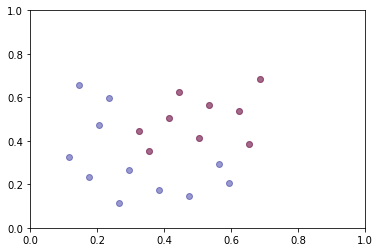

In [9]:
plot_sample(first_sample, existing_points)

Now we only need to reuse these points by creating a valid Latin Hypercube with them. The last plot shows the two samples including the overlapping points.

In [10]:
second_points_dict = get_next_trust_region_points_latin_hypercube(
    center=second_center,
    radius=second_radius,
    n_points=n_points,
    existing_points=existing_points,
    optimality_criterion="maximin",
    n_iter=100_000,
)

second_sample = second_points_dict["points"]

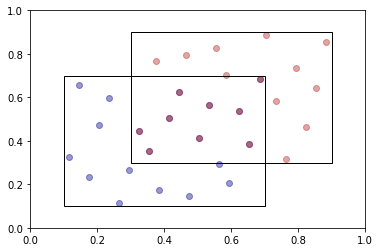

In [11]:
plot_sample(
    first_sample,
    second_sample,
    frames=[(first_center, first_radius), (second_center, second_radius)],
)